# Model

In [13]:
import pandas as pd
import torch
import sklearn.model_selection
import sklearn.preprocessing

from matplotlib import pyplot as plt

%matplotlib inline

### Load Data

In [2]:
df = pd.read_pickle('data/processed.pkl')
df = df.set_index('DATE')  # Index for timeseries is datetime

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 592 entries, 1963-01-01 to 2012-04-01
Data columns (total 20 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   MSACSR                                                                     592 non-null    float64
 1   MSPUS                                                                      592 non-null    float64
 2   S&P Comp.                                                                  592 non-null    float64
 3   Dividend                                                                   592 non-null    float64
 4   Earnings                                                                   592 non-null    float64
 5   Consumer Price Index CPI                                                   592 non-null    float64
 6   Long Interest Rate GS10                

### Data Pre-Processing

In [3]:
X = df.drop('MSPUS', axis='columns')
y = df['MSPUS'].values
y = y.reshape(-1, 1)  # Put target variable into column vector shape

print(X.shape, y.shape)

(592, 19) (592, 1)


In [6]:
# Make train and validation sets
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.1)

# Convert datasets to nodes in computational graph
X_train_tensors = torch.Tensor(X_train.values)
y_train_tensors = torch.Tensor(y_train)
X_val_tensors = torch.Tensor(X_val.values)
y_val_tensors = torch.Tensor(y_val)

# Convert to sequential data for pytorch
X_train_tensors = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_val_tensors = torch.reshape(X_val_tensors, (X_val_tensors.shape[0], 1, X_val_tensors.shape[1]))

print(X_train_tensors.shape)
print(X_val_tensors.shape)



torch.Size([532, 1, 19])
torch.Size([60, 1, 19])


### Define the Model

In [7]:
class LSTM(torch.nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = torch.nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            batch_first=True
                           )
        self.fully_connected1 = torch.nn.Linear(hidden_size, 128)
        self.fully_connected2 = torch.nn.Linear(128, num_classes)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        # Initialize states
        initial_hidden_state   = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        initial_internal_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Propogate forward
        output, (hidden_state, internal_state) = self.lstm(x, (initial_hidden_state, initial_internal_state))
        hidden_state = hidden_state.view(-1, self.hidden_size)  # Reshape for next dense layer
        output = self.relu(hidden_state)
        output = self.fully_connected1(output)
        output = self.relu(output)
        output = self.fully_connected2(output)
        
        return output
        

### Run Model

In [8]:
# Model parameters
N_CLASSES = 1
INPUT_SIZE = X_train_tensors.shape[2]  # Number of features
HIDDEN_SIZE = 2 # Number of features in hidden state
N_LAYERS = 1  # Number of stacked LSTM layers
BIAS = X_train_tensors.shape[1]

# Training parameters
N_EPOCHS = 100000
LEARNING_RATE = 0.01
loss_func = torch.nn.MSELoss()


lstm = LSTM(N_CLASSES, INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, BIAS)

# Training loop
optimizer = torch.optim.Adam(lstm.parameters(), lr=LEARNING_RATE)
for epoch_i in range(1, N_EPOCHS+1):
    # Forward propogation
    outputs = lstm.forward(X_train_tensors)
    optimizer.zero_grad()  # Manually set gradient to 0 here
    
    # Backward propogation
    np_outputs = outputs.detach().numpy()
    #if np.all(np_outputs == np_outputs[0]):
        #print('Epoch {}: All outputs the same'.format(epoch_i))
    loss = loss_func(outputs, y_train_tensors)
    loss.backward()
    
    optimizer.step()
    if epoch_i % 1000 == 0:
        print('Epoch: {}, loss: {:.2f}'.format(epoch_i, loss.item()))

Epoch: 1000, loss: 12627835904.00
Epoch: 2000, loss: 6801827840.00
Epoch: 3000, loss: 5279175168.00
Epoch: 4000, loss: 5229205504.00
Epoch: 5000, loss: 5229145088.00
Epoch: 6000, loss: 5229144064.00
Epoch: 7000, loss: 5229144064.00
Epoch: 8000, loss: 5229144064.00
Epoch: 9000, loss: 5229144064.00
Epoch: 10000, loss: 5229144064.00
Epoch: 11000, loss: 5229144064.00
Epoch: 12000, loss: 5229144064.00
Epoch: 13000, loss: 5229144576.00
Epoch: 14000, loss: 5229144576.00
Epoch: 15000, loss: 5229144576.00
Epoch: 16000, loss: 5229144064.00
Epoch: 17000, loss: 5229144064.00
Epoch: 18000, loss: 5229144064.00
Epoch: 19000, loss: 5229144576.00
Epoch: 20000, loss: 5229144064.00
Epoch: 21000, loss: 5229144064.00
Epoch: 22000, loss: 5229144576.00
Epoch: 23000, loss: 5229143552.00
Epoch: 24000, loss: 5229144064.00
Epoch: 25000, loss: 5229144064.00
Epoch: 26000, loss: 5229144064.00
Epoch: 27000, loss: 5229144064.00
Epoch: 28000, loss: 5229144064.00
Epoch: 29000, loss: 5229143552.00
Epoch: 30000, loss: 52

### Evaluate

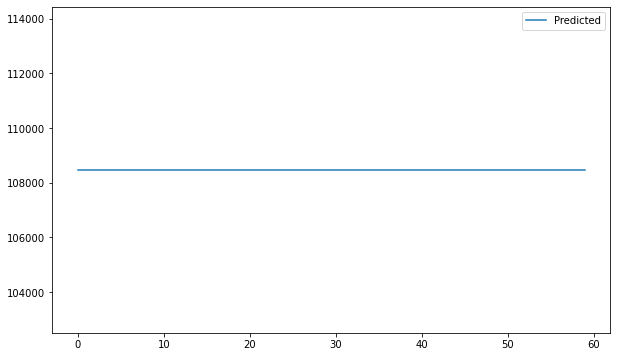

In [16]:
val_predictions = lstm(X_val_tensors).data.numpy()  # Forward pass

plt.figure(figsize=(10, 6))

#plt.plot(y_val, label='Actual')
plt.plot(val_predictions, label='Predicted')
plt.legend()
plt.show()

In [17]:
print(y_val_tensors.mean())

tensor(122947.7812)
